**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of a dateset related to cancellations of travel packages.

Packages are a type of travel product that include flight tickets and hotel reservations.

### Setup

In [84]:
import os

import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import src.utils as utils
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gutils = GoogleUtils()

### Load data

In [3]:
root = os.getcwd()

In [4]:
query = utils.read_file(f'{root}/src/queries/package_cancellation_data.sql')
df_cancel = gutils.read_from_bq(query)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [6]:
df_cancel.head()

,operation_order_id,operation_id,order_id,order_date,origin_city,order_origin_city,origin_state,origin_country,destination_type,destination_city,...,first_valid_date_brt,last_valid_date_brt,first_possible_wish_date_brt,first_wish_date_brt,second_wish_date_brt,third_wish_date_brt,operation_status_id,operation_status_name,last_update_status_date_brt,qty_status_changes
0,-5491122872638631047,NaN,-6623802656111529296,2018-06-28,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Joanesburgo,...,2019-03-01,2019-11-30,None,2019-05-11,2019-06-08,2019-07-06,NaN,None,2018-07-13,2
1,7489639055654340655,6.293305e+18,6071263481676392773,2019-11-29,Brasília,Brasília,Distrito Federal,Brasil,Nacional,Ilhéus,...,2020-03-01,2020-11-30,None,2020-03-07,2020-03-14,2020-03-21,2.0,Cotando aéreo,2021-01-11,3
2,-134622430558610287,NaN,8772484445114060697,2020-04-06,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Barcelona,...,2021-03-01,2022-06-30,None,2021-05-15,2021-05-22,2021-05-29,NaN,None,2021-03-14,2
3,-8892288855306560503,NaN,6650677439419640636,2020-04-18,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Havana,...,2021-03-01,2022-11-30,None,2021-11-07,2022-04-03,2022-04-10,NaN,None,2021-09-08,3
4,862668744913335110,-8.055071e+18,5870891268859063188,2020-04-24,Belo Horizonte,Belo Horizonte,Minas Gerais,Brasil,Internacional,Noord,...,2021-03-01,2022-11-30,None,2022-09-08,2022-09-14,2022-09-20,14.0,Cancelada,2022-04-02,3


Save locally:

In [7]:
df_cancel.to_csv(f'{root}/src/data/cancellation_data.csv')

### Data Cleaning

We have a lot of null values:

In [8]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299702 entries, 0 to 299701
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   operation_order_id            299702 non-null  int64  
 1   operation_id                  154315 non-null  float64
 2   order_id                      299702 non-null  int64  
 3   order_date                    299702 non-null  object 
 4   origin_city                   299702 non-null  object 
 5   order_origin_city             299702 non-null  object 
 6   origin_state                  299702 non-null  object 
 7   origin_country                299702 non-null  object 
 8   destination_type              299702 non-null  object 
 9   destination_city              299702 non-null  object 
 10  destination_state             299702 non-null  object 
 11  destination_country           299702 non-null  object 
 12  qty_people                    299702 non-nul

- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started. 
- `origin_city` and `origin_state` miss more than half of the data, but `order_origin_city` has the same purpose of `origin_city`. So, we'll see if it's possible to consider the `order_origin_city` valid and if we can use it to try to fill up the missing data of `origin_state`. 
- We can drop the `origin_country` column because this product is offer only to Brazil.
- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date_brt` and `last_form_fill_date_brt` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events.
- `first_possible_wish_date_brt` is completely empty, so we'll remove the column.
- The columns `first_wish_date_brt`, `second_wish_date_brt` and `third_wish_date_brt` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information.
- The columns `operation_status_name` and `operation_status_id` are related to the status of the operation process, if a order was cancelled before the start of the operation, this information doesn't exists. So we'll use only the `operation_status_name` information, replacing the missing values with a non-started status name.
- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.

Next we'll proceed to execute this modifications.

In [9]:
(df_cancel.isna().sum()/df_cancel.shape[0])*100

operation_order_id                0.000000
operation_id                     48.510520
order_id                          0.000000
order_date                        0.000000
origin_city                       0.000000
order_origin_city                 0.000000
origin_state                      0.000000
origin_country                    0.000000
destination_type                  0.000000
destination_city                  0.000000
destination_state                 0.000000
destination_country               0.000000
qty_people                        0.000000
qty_dailies                       0.000000
accommodation_type                7.533817
filled_form                       0.000000
first_form_fill_date_brt          0.000000
last_form_fill_date_brt           0.000000
first_valid_date_brt              0.001001
last_valid_date_brt               0.001001
first_possible_wish_date_brt    100.000000
first_wish_date_brt               0.001668
second_wish_date_brt              0.001668
third_wish_

Converting columns to boolean:

In [19]:
df = utils.convert_to_boolean(df_cancel, 'operation_id')
df = utils.convert_to_boolean(df, 'filled_form')

Looking at order_origin_city:

There's a lot of inconsistencies between the two cities columns, so we'll consider only the common information to fill up the state column.

In [20]:
df[['origin_city', 'order_origin_city']].loc[df[['origin_city', 'order_origin_city']].origin_city != df[['origin_city', 'order_origin_city']].order_origin_city].drop_duplicates()

,origin_city,order_origin_city
24814,Rio de Janeiro,São Paulo
133395,São Paulo,Cuiabá
217700,Rio de Janeiro,Su00e3o Paulo
236548,Porto Alegre,São Paulo
277943,Curitiba,Fortaleza
280345,São Paulo,Sao Paulo


In [27]:
city_state = df[['origin_city', 'order_origin_city', 'origin_state']].drop_duplicates().dropna(how='any')
city_state = city_state.loc[city_state.order_origin_city == city_state.origin_city]
city_state_dict = {city: city_state.loc[city_state.order_origin_city == city].origin_state.values[0] for city in city_state.order_origin_city.values}

In [28]:
city_state_dict

{'São Paulo': 'São Paulo',
 'Brasília': 'Distrito Federal',
 'Belo Horizonte': 'Minas Gerais',
 'Salvador': 'Bahia',
 'Rio de Janeiro': 'Rio de Janeiro',
 'Porto Alegre': 'Rio Grande do Sul',
 'Vitória': 'Espírito Santo',
 'Curitiba': 'Paraná',
 'Recife': 'Pernambuco',
 'Goiânia': 'Goiás',
 'Belém': 'Pará',
 'Campo Grande': 'Mato Grosso do Sul',
 'Cuiabá': 'Mato Grosso',
 'Natal': 'Rio Grande do Norte',
 'Manaus': 'Amazonas',
 'Aracaju': 'Sergipe',
 'Florianópolis': 'Santa Catarina',
 'Foz do Iguaçu': 'Paraná',
 'Fortaleza': 'Ceará',
 'João Pessoa': 'Paraíba',
 'Maceió': 'Alagoas',
 'Campinas': 'São Paulo',
 'Porto Velho': 'Rondônia',
 'Palmas': 'Tocantins',
 'Boa Vista': 'Roraima',
 'Macapá': 'Amapá',
 'Porto Seguro': 'Bahia',
 'Ribeirão Preto': 'São Paulo',
 'Vitoria da Conquista': 'Bahia',
 'Guarulhos': 'São Paulo',
 'Teresina': 'Piauí',
 'São Luís': 'Maranhão',
 'Rio Branco': 'Acre'}

In [29]:
df.loc[df.origin_state.isna(), 'origin_state'] = df['order_origin_city'].map(city_state_dict)

We were able to fill up all the missing state information:

In [30]:
(df.origin_state.isna().sum()/df.shape[0])*100

0.0

Drop some columns:

In [31]:
df = df.drop(['operation_order_id', 'operation_id', 'order_id', 'origin_country', 'first_possible_wish_date_brt', 'first_form_fill_date_brt', 'last_form_fill_date_brt', 'origin_city', 'first_wish_date_brt', 'second_wish_date_brt', 'third_wish_date_brt', 'operation_status_id'], axis=1)

Filling up the operation_status_name column:

In [32]:
df.loc[df.operation_status_name.isna(), 'operation_status_name'] = 'not started'

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data.

In [36]:
df.loc[~df.accommodation_type.isna()].accommodation_type

0                           Apartamento Duplo ou Individual
1                          Apartamento individual ou duplo.
2                                        Apartamento duplo.
3                                        Apartamento duplo.
4                                        Apartamento duplo.
                                ...                        
299697                                   Apartamento duplo.
299698                            Apartamento duplo casal. 
299699                            Apartamento duplo casal. 
299700    Apartamento duplo ou triplo, de acordo com a o...
299701                            Apartamento duplo casal. 
Name: accommodation_type, Length: 277123, dtype: object

In [45]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [48]:
df['accommodation_type'] = df.accommodation_type.str.lower()
df.loc[df.accommodation_type.str.contains(','), 'accommodation_type'] = 'multiple'
df.loc[df.accommodation_type.str.contains('individual'), 'accommodation_type'] = 'individual'
df.loc[df.accommodation_type.str.contains('dupl'), 'accommodation_type'] = 'duplo'
df.loc[df.accommodation_type.str.contains('tripl'), 'accommodation_type'] = 'triplo'

Now we can just drop the few rows with missing value:

In [81]:
df = df.dropna(how='any')

Now we're going to change the dtype of some columns:

In [108]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['first_valid_date_brt'] = pd.to_datetime(df['first_valid_date_brt'])
df['last_valid_date_brt'] = pd.to_datetime(df['last_valid_date_brt'])
df['last_update_status_date_brt'] = pd.to_datetime(df['last_update_status_date_brt'])

df['qty_people'] = df['qty_people'].astype(int)
df['qty_dailies'] = df['qty_dailies'].astype(int)

### Analysis

Let's start analyzing the data taking a look into the categorical data.

In [159]:
sns.set_style('darkgrid')
sns.set_palette('pastel')

In [111]:
categorical_features = df.select_dtypes(include=['object_']).columns

In [135]:
origin_city = df.groupby('order_origin_city').count().order_date.reset_index()
origin_city = origin_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)

We can verify that the 5 top origin cities are São Paulo, Rio de Janeiro, Belo Horizonte, Brasília and Curitiba. They represent more than 90% of the origins.

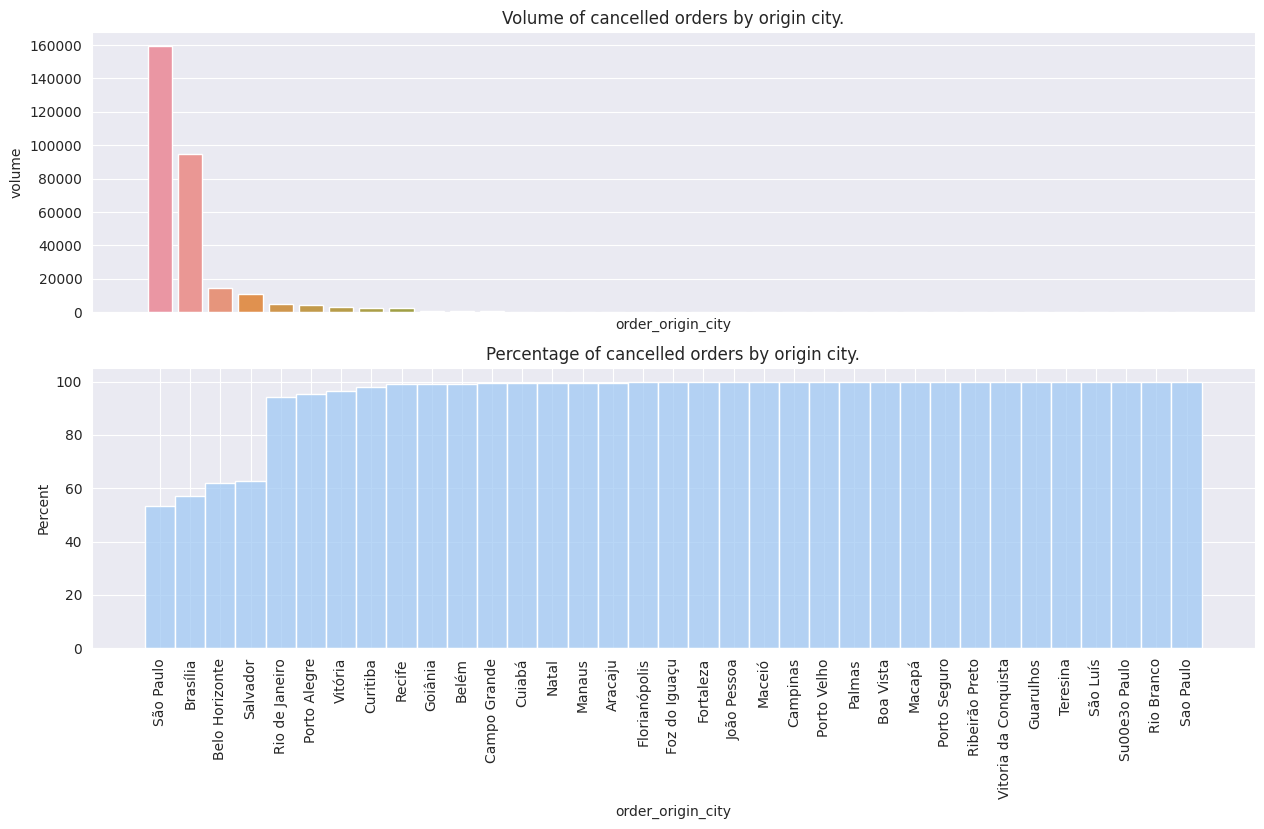

In [231]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_city, x='order_origin_city', y='volume', ax=ax[0])
sns.histplot(df, x='order_origin_city', ax=ax[1], stat='percent', cumulative=True)

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin city.');
ax[1].set_title('Percentage of cancelled orders by origin city.');

In [232]:
origin_state = df.groupby('origin_state').count().order_date.reset_index()
origin_state = origin_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)

We can verify that ...

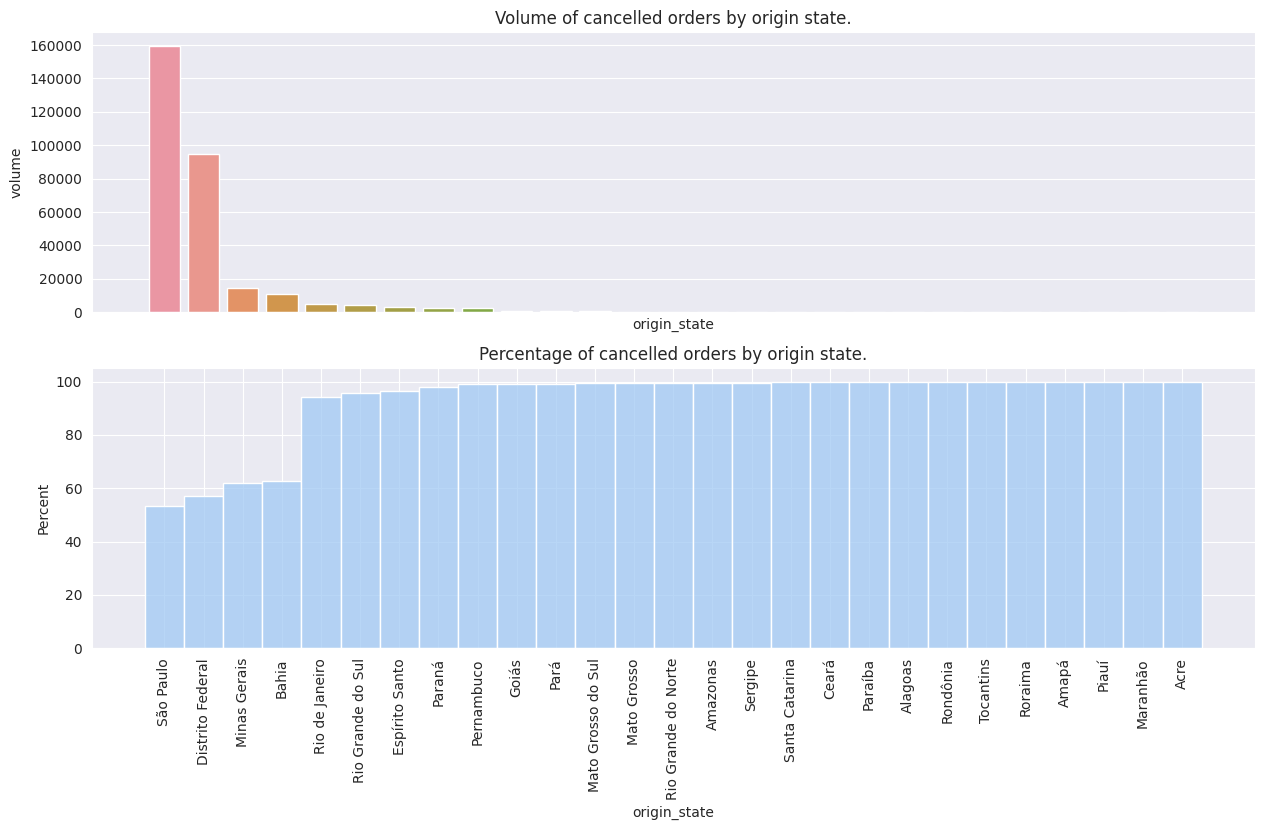

In [233]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_state, x='origin_state', y='volume', ax=ax[0])
sns.histplot(df, x='origin_state', ax=ax[1], stat='percent', cumulative=True)

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin state.');
ax[1].set_title('Percentage of cancelled orders by origin state.');

Looking at destinations:

In [255]:
destination_city = df.groupby('destination_city').count().order_date.reset_index()
destination_city = destination_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)

Looks like international destinations have more cancellations, we'll confirm that insight next.

In [256]:
# limit the destination cities to have an interpretable plot
destination_city = destination_city.head(50)

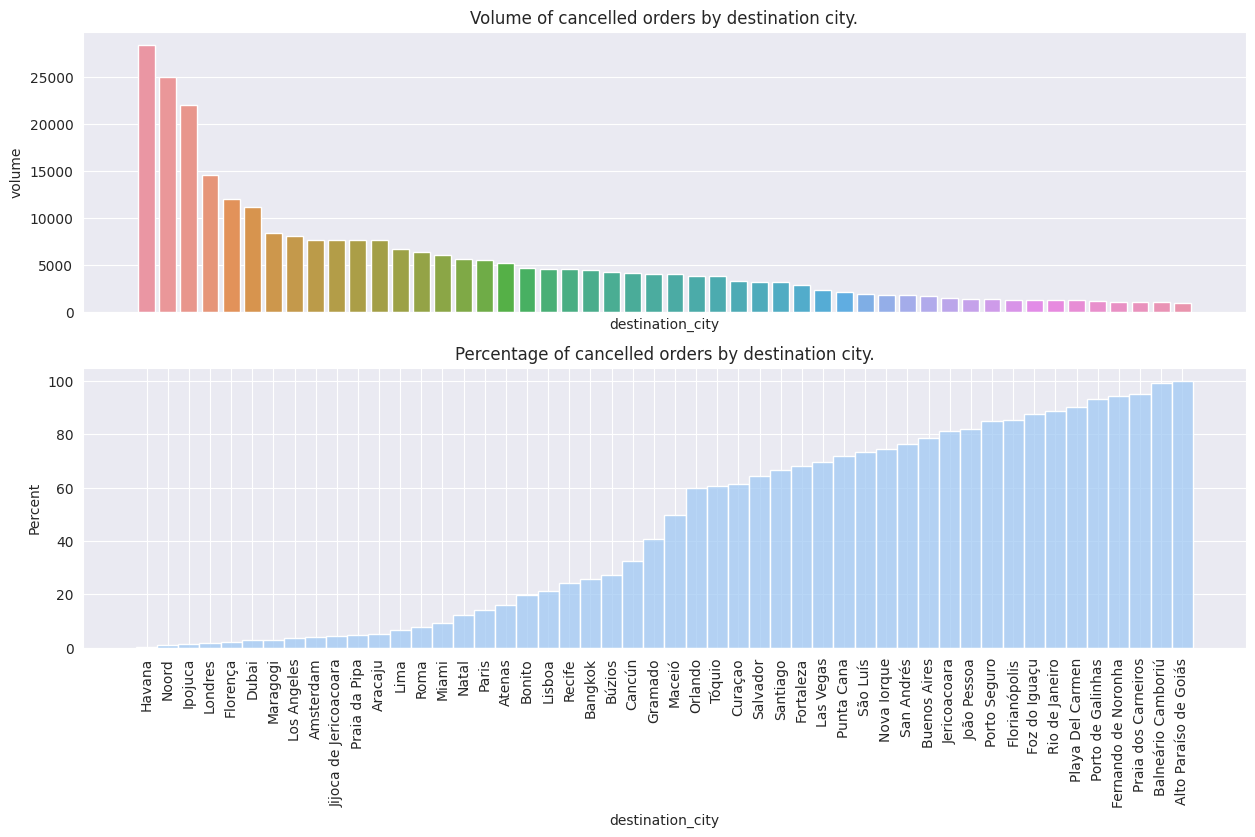

In [257]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_city, x='destination_city', y='volume', ax=ax[0])
sns.histplot(df.loc[df.destination_city.isin(destination_city.destination_city)], x='destination_city', ax=ax[1], stat='percent', cumulative=True)

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination city.');
ax[1].set_title('Percentage of cancelled orders by destination city.');

In [262]:
destination_type = df.groupby('destination_type').count().order_date.reset_index()
destination_type = destination_type.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_type['percent'] = destination_type['volume']/df.shape[0]

<AxesSubplot:xlabel='destination_type', ylabel='percent'>

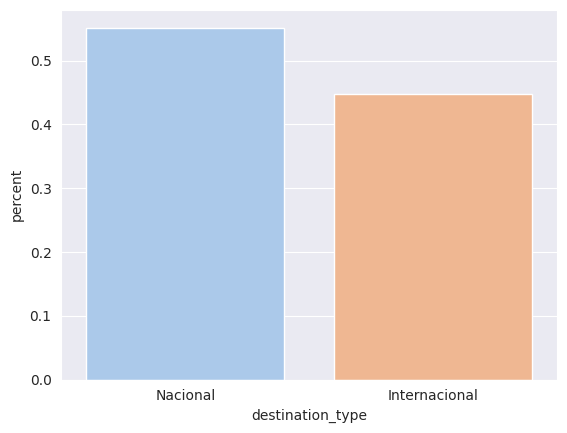

In [263]:
sns.barplot(destination_type, x='destination_type', y='percent')

In [265]:
import plotly.graph_objects as go

In [267]:
data = go.Sankey(link=df[['origin_state', 'destination_city']])
fig = go.Figure(data)

ValueError: 
    Invalid value of type 'pandas.core.frame.DataFrame' received for the 'link' property of sankey
        Received value:             origin_state       destination_city
0              São Paulo            Joanesburgo
1       Distrito Federal                 Ilhéus
2              São Paulo              Barcelona
3              São Paulo                 Havana
4           Minas Gerais                  Noord
...                  ...                    ...
299697         São Paulo  Alto Paraíso de Goiás
299698         São Paulo  Alto Paraíso de Goiás
299699         São Paulo  Alto Paraíso de Goiás
299700         São Paulo  Alto Paraíso de Goiás
299701    Rio de Janeiro  Alto Paraíso de Goiás

[299699 rows x 2 columns]

    The 'link' property is an instance of Link
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.sankey.Link`
      - A dict of string/value properties that will be passed
        to the Link constructor

        Supported dict properties:
            
            arrowlen
                Sets the length (in px) of the links arrow, if
                0 no arrow will be drawn.
            color
                Sets the `link` color. It can be a single
                value, or an array for specifying color for
                each `link`. If `link.color` is omitted, then
                by default, a translucent grey link will be
                used.
            colorscales
                A tuple of :class:`plotly.graph_objects.sankey.
                link.Colorscale` instances or dicts with
                compatible properties
            colorscaledefaults
                When used in a template (as layout.template.dat
                a.sankey.link.colorscaledefaults), sets the
                default property values to use for elements of
                sankey.link.colorscales
            colorsrc
                Sets the source reference on Chart Studio Cloud
                for `color`.
            customdata
                Assigns extra data to each link.
            customdatasrc
                Sets the source reference on Chart Studio Cloud
                for `customdata`.
            hoverinfo
                Determines which trace information appear when
                hovering links. If `none` or `skip` are set, no
                information is displayed upon hovering. But, if
                `none` is set, click and hover events are still
                fired.
            hoverlabel
                :class:`plotly.graph_objects.sankey.link.Hoverl
                abel` instance or dict with compatible
                properties
            hovertemplate
                Template string used for rendering the
                information that appear on hover box. Note that
                this will override `hoverinfo`. Variables are
                inserted using %{variable}, for example "y:
                %{y}" as well as %{xother}, {%_xother},
                {%_xother_}, {%xother_}. When showing info for
                several points, "xother" will be added to those
                with different x positions from the first
                point. An underscore before or after
                "(x|y)other" will add a space on that side,
                only when this field is shown. Numbers are
                formatted using d3-format's syntax
                %{variable:d3-format}, for example "Price:
                %{y:$.2f}". https://github.com/d3/d3-
                format/tree/v1.4.5#d3-format for details on the
                formatting syntax. Dates are formatted using
                d3-time-format's syntax %{variable|d3-time-
                format}, for example "Day: %{2019-01-01|%A}".
                https://github.com/d3/d3-time-
                format/tree/v2.2.3#locale_format for details on
                the date formatting syntax. The variables
                available in `hovertemplate` are the ones
                emitted as event data described at this link
                https://plotly.com/javascript/plotlyjs-
                events/#event-data. Additionally, every
                attributes that can be specified per-point (the
                ones that are `arrayOk: true`) are available.
                variables `value` and `label`. Anything
                contained in tag `<extra>` is displayed in the
                secondary box, for example
                "<extra>{fullData.name}</extra>". To hide the
                secondary box completely, use an empty tag
                `<extra></extra>`.
            hovertemplatesrc
                Sets the source reference on Chart Studio Cloud
                for `hovertemplate`.
            label
                The shown name of the link.
            labelsrc
                Sets the source reference on Chart Studio Cloud
                for `label`.
            line
                :class:`plotly.graph_objects.sankey.link.Line`
                instance or dict with compatible properties
            source
                An integer number `[0..nodes.length - 1]` that
                represents the source node.
            sourcesrc
                Sets the source reference on Chart Studio Cloud
                for `source`.
            target
                An integer number `[0..nodes.length - 1]` that
                represents the target node.
            targetsrc
                Sets the source reference on Chart Studio Cloud
                for `target`.
            value
                A numeric value representing the flow volume
                value.
            valuesrc
                Sets the source reference on Chart Studio Cloud
                for `value`.
